In [1]:
import json
import os

from src.collocations import get_bigram_collocations, get_trigram_collocations, get_similar_glyphs
from src.discourse import plot_discourse
from src.nearest_neighbor import analyze_glyphs, glyph_bound
from src.processing import load_file, clean_lines, encode_lines, process_sequences
from src.search import search_glyphs
from src.segmentation import vectorize, get_distinctive_glyphs, plot_breakpoints, segment_text

# Text I (Santiago Staff)

### Data processing

In [2]:
# Read the data, reencode to Horley (2021)

raw_I_data = load_file('data/I.csv')
clean_I_data = clean_lines(raw_I_data)
encoded_I_data = encode_lines(clean_I_data)

raw_I_sequences = load_file('data/I_stanzas.txt')
clean_I_sequences = clean_lines(raw_I_sequences)
encoded_I_sequences = encode_lines(clean_I_sequences)

_, sequences_I = process_sequences(encoded_I_sequences)

### Glyph collocations

In [3]:
# Most likely collocations respective to glyph 76

bigrams_I = get_bigram_collocations(sequences_I)
bigrams_I

[(('90', '<76>'), 97.16250329356825),
 (('600.6', '<76>'), 78.25860208581875),
 (('430', '<76>'), 47.240107994726955),
 (('76', '<76>'), 30.104575598793048),
 (('4', '<76>'), 14.682566641271166),
 (('90.21', '<76>'), 14.682566641271166),
 (('99', '<76>'), 14.55035615840926),
 (('633', '<76>'), 13.739369108765693),
 (('700', '<76>'), 12.735363428309686),
 (('451', '<76>'), 12.367639882136633),
 (('<76>', '532'), 84.59978407410732),
 (('<76>', '11'), 53.994081532373),
 (('<76>', '71'), 50.553694142601785),
 (('<76>', '70'), 40.276386415974216),
 (('<76>', '4f'), 27.00166369979241),
 (('<76>', '75'), 26.963627647197843),
 (('<76>', '10.79f'), 25.734965560765367),
 (('<76>', '21.1'), 22.04695739188478),
 (('<76>', '57'), 18.362827861287688),
 (('<76>', '2a.10'), 17.705771214569516),
 (('600', '</s>'), 27.51142801881818),
 (('59', '</s>'), 15.52477702605022),
 (('76', '</s>'), 13.7241633757681),
 (('90', '</s>'), 11.58722187324404),
 (('2', '</s>'), 11.454007156238488),
 (('270.6', '</s>'),

In [4]:
# Most frequent collocations respective to glyph 76

bigrams_I_frequency = get_bigram_collocations(sequences_I, measure="frequency")
bigrams_I_frequency

[(('90', '<76>'), 53),
 (('430', '<76>'), 27),
 (('600.6', '<76>'), 26),
 (('76', '<76>'), 26),
 (('700', '<76>'), 16),
 (('71', '<76>'), 14),
 (('2', '<76>'), 9),
 (('200.10', '<76>'), 9),
 (('1v', '<76>'), 9),
 (('451', '<76>'), 8),
 (('<76>', '71'), 33),
 (('<76>', '532'), 31),
 (('<76>', '70'), 21),
 (('<76>', '11'), 21),
 (('<76>', '600'), 17),
 (('<76>', '4f'), 11),
 (('<76>', '2a.10'), 10),
 (('<76>', '75'), 9),
 (('<76>', '21'), 8),
 (('<76>', '700'), 8),
 (('90', '</s>'), 26),
 (('600', '</s>'), 24),
 (('76', '</s>'), 20),
 (('700', '</s>'), 14),
 (('2', '</s>'), 12),
 (('200.10', '</s>'), 9),
 (('59', '</s>'), 8),
 (('27', '</s>'), 8),
 (('430', '</s>'), 8),
 (('670', '</s>'), 7)]

In [5]:
# Most likely associations of the first two stanza glyphs

trigrams_I = get_trigram_collocations(sequences_I)
trigrams_I

[(('90', '<76>', '532'), 183.0776021499619),
 (('600.6', '<76>', '532'), 165.16365641341076),
 (('90', '<76>', '11'), 151.3960287657734),
 (('90', '<76>', '71'), 148.75195880959916),
 (('90', '<76>', '70'), 144.70011222355433),
 (('90', '<76>', '21.1'), 135.63192129516526),
 (('430', '<76>', '532'), 134.0261436774235),
 (('600.6', '<76>', '70'), 123.15250771221541),
 (('90', '<76>', '57'), 118.07396680411725),
 (('90', '<76>', '2a.10'), 117.38610104718003)]

In [6]:
# Most frequent associations of the first two stanza glyphs

trigrams_I_frequency = get_trigram_collocations(sequences_I, measure="frequency")
trigrams_I_frequency

[(('90', '<76>', '70'), 7),
 (('755', '<76>', '75'), 5),
 (('90', '<76>', '21.1'), 5),
 (('90', '<76>', '71'), 5),
 (('430', '<76>', '532'), 4),
 (('600.6', '<76>', '70'), 4),
 (('71', '<76>', '10.79f'), 4),
 (('600.6', '<76>', '532'), 4),
 (('200.10', '<76>', '71'), 4),
 (('76', '<76>', '71'), 4)]

In [7]:
# Percentage of stanzas that show some repetition
# of the same glyph in different positions

_, percentages_I = get_similar_glyphs(sequences_I)
percentages_I

{'XYX': 0.05, 'XXZ': 0.045454545454545456, 'XYY': 0.02727272727272727}

### Text segmentation

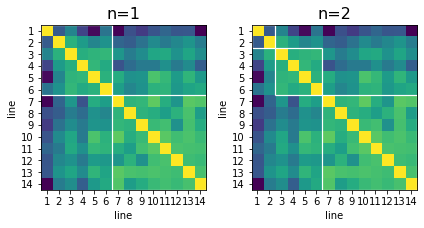

In [8]:
# Vectorize the whole text using count vectorizer and
# plot the segments based on cosine distance using one
# and two breakpoints

vectorized_text, _ = vectorize(encoded_I_data)
bkpts = plot_breakpoints(vectorized_text, [1, 2])

In [9]:
# Most distinctive glyphs of each segment using TF-IDF

segmented_text = segment_text(encoded_I_data, bkpts[0])
distinctive_glyphs = get_distinctive_glyphs(segmented_text)
distinctive_glyphs

[['600', '76', '430', '430.76', '90', '532', '90.76', '700.76', '75', '700'],
 ['90.76', '71', '11', '76', '532', '600.6.76', '600', '90', '70', '2a.10']]

### Glyph distribution

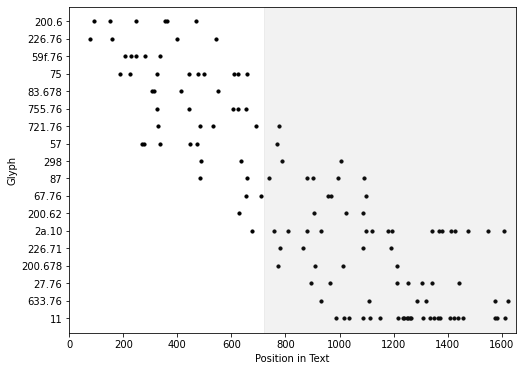

In [10]:
# Glyphs that show significant clustering in their distribution
# within the text

clustered_glyphs, _ = analyze_glyphs(encoded_I_data)
plot_discourse(clustered_glyphs, encoded_I_data, bkpt=bkpts[0][0])

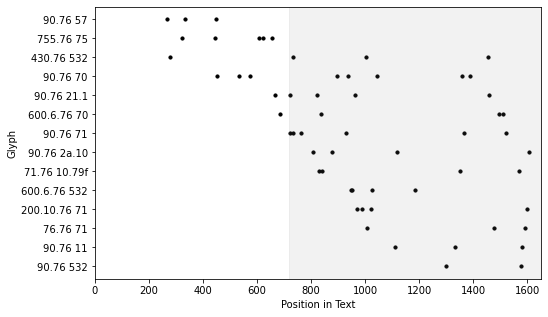

In [11]:
# Distribution of the most likely/frequent associations between
# the first two stanza glyphs

trigrams_formatted = [[f'{trigram[0][0]}.76', trigram[0][2]] for trigram in trigrams_I]
for trigram in trigrams_I_frequency:
    if [f'{trigram[0][0]}.76', trigram[0][2]] not in trigrams_formatted:
        trigrams_formatted.append([f'{trigram[0][0]}.76', trigram[0][2]])
trigrams_sorted = sorted(trigrams_formatted, key=lambda x: glyph_bound(x, encoded_I_data))
plot_discourse(trigrams_sorted, encoded_I_data, bkpt=bkpts[0][0], figsize=(8,5))

### Matches outside of text I

In [12]:
# Search the corpus for combinations of the first two stanza glyphs
# occuring more than once

XY = [(seq[0], seq[2]) for seq in sequences_I if '?' not in seq[0] and '?' not in seq[2]]
XY = [glyphs for glyphs in set(XY) if XY.count(glyphs) > 1]
search_results = search_glyphs(XY)
search_results

{'90 11': ['Aa2'],
 '90 5': ['Pv1', 'Qv2', 'Hr11'],
 '381.6 11': ['Aa8'],
 '600.6 600': ['Cb2'],
 '9 2': ['Sb8'],
 '90 70': ['Sb8', 'Aa2'],
 '430 48f': ['Pv7'],
 '700 381': ['Qr6', 'Er8'],
 '430 5': ['Ab3'],
 '90 71': ['Ev2']}

# Text Gv (verso of Small Santiago Tablet)

### Data processing

In [13]:
raw_Gv_sequences = load_file('data/Gv_stanzas.txt')
clean_Gv_sequences = clean_lines(raw_Gv_sequences)
encoded_Gv_sequences = encode_lines(clean_Gv_sequences)
_, sequences_Gv = process_sequences(encoded_Gv_sequences)

### Glyph collocations

In [14]:
# Most likely collocations respective to glyph 76

bigrams_Gv = get_bigram_collocations(sequences_Gv)
bigrams_Gv

[(('430', '<76>'), 9.509051931396879),
 (('660', '<76>'), 8.219849002902622),
 (('226.62', '<76>'), 4.668338287757836),
 (('670', '<76>'), 4.668338287757836),
 (('5', '<76>'), 1.6581776578573098),
 (('<76>', '200f'), 11.889009643209985),
 (('<76>', '290'), 8.219849002902622),
 (('<76>', '70'), 8.219849002902622),
 (('90f', '</s>'), 8.219849002902622),
 (('22', '</s>'), 6.195701346034667),
 (('59f', '</s>'), 4.668338287757836),
 (('32', '</s>'), 2.29554797272426),
 (('700', '</s>'), 1.192308858114244)]

In [15]:
# Percentage of stanzas that show some repetition
# of the same glyph in different positions

_, percentages_Gv = get_similar_glyphs(sequences_Gv)
percentages_Gv

{'XYX': 0.16216216216216217,
 'XXZ': 0.10810810810810811,
 'XYY': 0.16216216216216217}

# Text T (Honolulu Tablet)

### Data processing

In [16]:
raw_T_sequences = load_file('data/T_stanzas.txt')
clean_T_sequences = clean_lines(raw_T_sequences)
encoded_T_sequences = encode_lines(clean_T_sequences)
_, sequences_T = process_sequences(encoded_T_sequences)

### Glyph collocations

In [17]:
# Most likely collocations respective to glyph 76

bigrams_T = get_bigram_collocations(sequences_T)
bigrams_T

[(('90', '<76>'), 5.757255155656027),
 (('430', '<76>'), 2.0237729037633523),
 (('<76>', '532'), 11.92949980349836),
 (('<76>', '71'), 2.9151918017401512),
 (('<76>', '430'), 2.0237729037633523),
 (('<76>', '70'), 2.0237729037633523),
 (('76', '</s>'), 4.349628257474901)]